# Reshaping DataFrames

Files needed = ('gameshow.csv', 'WEOOct2021all.csv', 'zillow.csv')

We are learning how to deal with complex datasets in pandas. We began by tackling the multiIndex and now we turn to panel data and its various representations.  

Panel data have (at least) three dimensions, for example, a panel might record

1. several variables (income, age, spending on gasoline)
2. regarding several people
3. over time

The multiIndex gives us a natural way to handle this data. In this notebook, we work on ways to get our datasets into shapes that are amenable to analysis. 

Reshaping is important and necessary, and often a particularly painful aspect of using administrative data or data from apis.

A standard structure for a DataFrame has **observations as rows and columns as variables**. Many methods expect DataFrames to be organized this way but raw data are often not organized in this manner. This DataFrame structure is often referred to as *tidy data*. [This](https://www.jstatsoft.org/article/view/v059i10) article by Wickham lays out the ideas. The first three sections are great reading. The rest of the paper shows how to tidy up data in R. We can do the same things in python. With enough suffering, you can do it in Stata, too. 

In [1]:
import pandas as pd                 # load pandas and shorten it to pd
import datetime as dt               # load datetime and shorten it to dt
import matplotlib.pyplot as plt     # for making figures
import seaborn as sns
import numpy as np

## Some panel data
Load the 'gameshow.csv' file. It contains scores and wins for an [award-winning](https://www.bafta.org/television/awards/comedy-entertainment-programme-1) [British game show](https://www.theatlantic.com/culture/archive/2023/03/taskmaster-game-show-productivity-parody/673225/). The different dimensions of the data are: **variables** (score, win); **series** (1-14 series, or seasons); **contestants** (by name); and  **episodes** (1-10). The column **value** contains the data associated with the contestant-episode-variable triplet. Each contestant appears in only one series; this would not be true if the data included holiday specials or tournaments. 
 
\[The data are were compiled on a [fan Wiki site](https://taskmaster.fandom.com/wiki/Contestant_Statistics); I make no claims regarding the accuracy of the data or anything else on the site. If you were using data like these in a project, you would want to verify the accuracy yourself or find a more trustworthy source.\] 

In [2]:
# load a data file with the score and win pattern of the game show
# notice that value is sometimes missing - fewer episodes in some series

game = pd.read_csv('gameshow.csv') 
game

,series,contestant,episode,var,value
0,1,Frank Skinner,1,score,19.0
1,1,Frank Skinner,1,win,1.0
2,1,Frank Skinner,2,score,9.0
3,1,Frank Skinner,2,win,0.0
4,1,Frank Skinner,3,score,15.0
...,...,...,...,...,...
1395,14,Sarah Millican,8,win,0.0
1396,14,Sarah Millican,9,score,18.0
1397,14,Sarah Millican,9,win,0.0
1398,14,Sarah Millican,10,score,15.0


In [3]:
game.describe()

,series,episode,value
count,1400.000000,1400.000000,1220.000000
mean,7.500000,5.500000,7.926230
std,4.032569,2.873308,8.261783
min,1.000000,1.000000,0.000000
25%,4.000000,3.000000,0.000000
50%,7.500000,5.500000,2.000000
75%,11.000000,8.000000,16.000000
max,14.000000,10.000000,30.000000


In [4]:
game.dtypes

series          int64
contestant     object
episode         int64
var            object
value         float64
dtype: object

### Long vs. wide (or stacked vs. unstacked)

The data in the file we just loaded is formatted as **long**: There are lots of rows and not many columns. Moving between long and **wide** (lots of columns, fewer rows) is a common task in setting up panel data sets. 

Pandas calls long data **stacked** and wide data **unstacked**. We use the `.stack()` and `.unstack()` methods for moving between long and wide with multiIndexed data. Stack and unstack do not work in place. They always return a copy, so we need to assign it to a variable.

The typical workflow is:

1. Set up the index
2. Stack or unstack

### Set up the index
`.stack()` and `.unstack()` work from the index. Since our data may be many-dimensional, multiIndexes are often useful. We start by getting the index set so that we can reshape our data. 

In [5]:
# move everything but the data values to the index
game = game.set_index(['series', 'contestant', 'episode', 'var'])
game = game.sort_index()
game

value
series contestant     episode var         
1      Frank Skinner  1       score   19.0
                              win      1.0
                      2       score    9.0
                              win      0.0
                      3       score   15.0
...                                    ...
14     Sarah Millican 8       win      0.0
                      9       score   18.0
                              win      0.0
                      10      score   15.0
                              win      0.0

[1400 rows x 1 columns]

## Unstack
We **unstack the data** to put the variables into columns. This creates a multiIndex over the columns.

In [6]:
# We pass unstack the name of the index level to take out of the index and spread across the rows. 
game_us = game.unstack('var') 
game_us.head(10)

value     
var                          score  win
series contestant    episode           
1      Frank Skinner 1        19.0  1.0
                     2         9.0  0.0
                     3        15.0  0.0
                     4        14.0  0.0
                     5        20.0  1.0
                     6        16.0  0.0
                     7         NaN  NaN
                     8         NaN  NaN
                     9         NaN  NaN
                     10        NaN  NaN

The data are now **wide** (or, at least, wider) and **tidy**. We have shortened the number of rows and increased the number of columns. This is my preferred way to shape this data because it puts the unit of observation in the row index. In this case, the unit of observation is a contestant-episode. 

The column index is now a multiIndex:

In [7]:
game_us.columns

MultiIndex([('value', 'score'),
            ('value',   'win')],
           names=[None, 'var'])

Some of the series had fewer than 10 episodes, so both `score` and `win` are missing. Let's drop missings.

In [8]:
game_us.dropna(inplace=True)
game_us.head(10)

value     
var                            score  win
series contestant      episode           
1      Frank Skinner   1        19.0  1.0
                       2         9.0  0.0
                       3        15.0  0.0
                       4        14.0  0.0
                       5        20.0  1.0
                       6        16.0  0.0
       Josh Widdicombe 1        13.0  0.0
                       2        16.0  0.0
                       3        22.0  1.0
                       4        16.0  1.0

We can unstack again to make the data even wider. As usual, we pass a list of names whose (combinations of) values we now want to be shown as columns. Intuitively, these 
```python
game.unstack(['episode', 'var'])
```
Now we have missings again, and the data are at the contestant level (as in the source).

In [9]:
# We pass unstack the name of the index level to take out of the index and spread across the rows. 
game_us2 = game.unstack(['episode', 'var'])
game_us2.head(10)

value                                              \
episode                      1          2          3          4          5    
var                       score  win score  win score  win score  win score   
series contestant                                                             
1      Frank Skinner       19.0  1.0   9.0  0.0  15.0  0.0  14.0  0.0  20.0   
       Josh Widdicombe     13.0  0.0  16.0  0.0  22.0  1.0  16.0  1.0  18.0   
       Roisin Conaty        7.0  0.0  21.0  1.0   9.0  0.0   9.0  0.0  14.0   
       Romesh Ranganathan  19.0  1.0  14.0  0.0  22.0  1.0  10.0  0.0  16.0   
       Tim Key             17.0  0.0  18.0  0.0  16.0  0.0   9.0  0.0  10.0   
2      Doc Brown            9.0  0.0  18.0  0.0  21.0  0.0  18.0  1.0  12.0   
       Joe Wilkinson        8.0  0.0  13.0  0.0  25.0  0.0  12.0  0.0  11.0   
       Jon Richardson      18.0  0.0  25.0  1.0  17.0  0.0  17.0  0.0  13.0   
       Katherine Ryan      17.0  0.0  19.0  0.0  30.0  1.0  15.0  0.0  13.0   
       Richard Osman       20.0  1.0  15.0  0.0  27.0  0.0   5.0  0.0  19.0   

                                                                               \
episode                           6          7         8         9         10   
var                        win score  win score win score win score win score   
series contestant                                                               
1      Frank Skinner       1.0  16.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Josh Widdicombe     0.0   9.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Roisin Conaty       0.0   8.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Romesh Ranganathan  0.0  12.0  0.0   NaN NaN   NaN NaN   NaN NaN   NaN   
       Tim Key             0.0  18.0  1.0   NaN NaN   NaN NaN   NaN NaN   NaN   
2      Doc Brown           0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Joe Wilkinson       0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Jon Richardson      0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Katherine Ryan      0.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   
       Richard Osman       1.0   NaN  NaN   NaN NaN   NaN NaN   NaN NaN   NaN   

                               
episode                        
var                       win  
series contestant              
1      Frank Skinner      NaN  
       Josh Widdicombe    NaN  
       Roisin Conaty      NaN  
       Romesh Ranganathan NaN  
       Tim Key            NaN  
2      Doc Brown          NaN  
       Joe Wilkinson      NaN  
       Jon Richardson     NaN  
       Katherine Ryan     NaN  
       Richard Osman      NaN

### Removing a level
The outermost level of the column multiIndex is 'value' and is not very useful. Let's drop it.

Note that the level does not have a name associated with it (`None` is not a name) so we need to use the number associated with the level. 

In [10]:
game_us.columns = game_us.columns.droplevel(level = 0)
game_us

var                            score  win
series contestant     episode            
1      Frank Skinner  1         19.0  1.0
                      2          9.0  0.0
                      3         15.0  0.0
                      4         14.0  0.0
                      5         20.0  1.0
...                              ...  ...
14     Sarah Millican 6         19.0  1.0
                      7         15.0  0.0
                      8         17.0  0.0
                      9         18.0  0.0
                      10        15.0  0.0

[610 rows x 2 columns]

In [11]:
game_us.columns

Index(['score', 'win'], dtype='object', name='var')

### Creating new variables
I want to know the scores conditional on winning. I don't want the non-winning scores to be filled in with anything; for example, if they were filled in with zeros, and I tried to calculate the mean, it would be biased downward by the many zero observations. I'm going to use `.loc` with a conditional statement. 

In [12]:
game_us.loc[game_us['win']==0, 'score_win'] = game_us['score']
game_us

var                            score  win  score_win
series contestant     episode                       
1      Frank Skinner  1         19.0  1.0        NaN
                      2          9.0  0.0        9.0
                      3         15.0  0.0       15.0
                      4         14.0  0.0       14.0
                      5         20.0  1.0        NaN
...                              ...  ...        ...
14     Sarah Millican 6         19.0  1.0        NaN
                      7         15.0  0.0       15.0
                      8         17.0  0.0       17.0
                      9         18.0  0.0       18.0
                      10        15.0  0.0       15.0

[610 rows x 3 columns]

As usual, pandas handles our missing observations gracefully. 

### Plotting with panels
Let's plot the scores across episodes, for a recent series. The plotting is straightforward, but we need to use our multiIndex skills to select the data. 

In [13]:
# Subset the data
game_us14 = game_us.xs(14, level='series')
# Get the contestant names for the most recent series
contestants = list(game_us14.xs(1, level='episode').index)
contestants

['Dara Ó Briain',
 'Fern Brady',
 'John Kearns',
 'Munya Chawawa',
 'Sarah Millican']

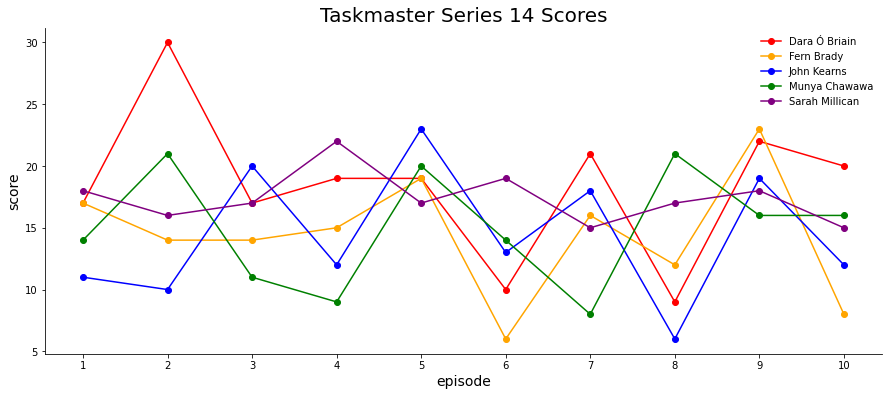

In [14]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(game_us14.loc['Dara Ó Briain'].index, game_us14.loc['Dara Ó Briain', 'score'], color='red', marker = 'o', label='Dara Ó Briain')
ax.plot(game_us14.loc['Fern Brady'].index, game_us14.loc['Fern Brady', 'score'], color='orange', marker = 'o', label='Fern Brady')
ax.plot(game_us14.loc['John Kearns'].index, game_us14.loc['John Kearns', 'score'], color='blue', marker = 'o', label='John Kearns')
ax.plot(game_us14.loc['Munya Chawawa'].index, game_us14.loc['Munya Chawawa', 'score'], color='green', marker = 'o', label='Munya Chawawa')
ax.plot(game_us14.loc['Dara Ó Briain'].index, game_us14.loc['Sarah Millican', 'score'], color='purple', marker = 'o', label='Sarah Millican')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Taskmaster Series 14 Scores', fontsize=20)
ax.set_ylabel('score', fontsize=14)
ax.set_xlabel('episode', fontsize=14)

ax.set_xticks(range(1,11,1))

ax.legend(frameon=False)

plt.show()

What have we here? Dara Ó Briain won the series, but lost many episodes. Sarah Millican wins the "steady as she goes" prize for least score volatility. John Kearns seems countercyclical - he must have a different set of skills than the other contestants.

Looking at my code for this figure I see that I basically repeated the same code five times. Not good! I should automate the plotting or use a package like seaborn to automate it for me.  

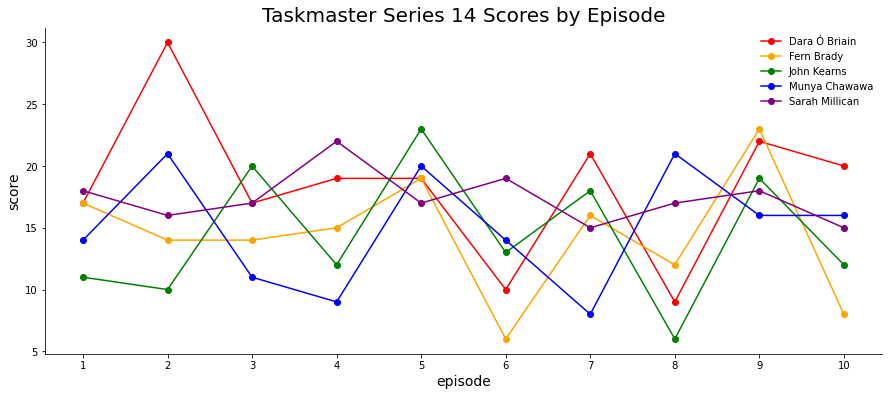

In [15]:
fig, ax = plt.subplots(figsize=(15,6))

for com, col in zip(contestants, ['red', 'orange', 'green', 'blue', 'purple']):
    ax.plot(game_us14.loc[com].index, game_us14.loc[com, 'score'], color=col, marker = 'o', label=com)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Taskmaster Series 14 Scores by Episode', fontsize=20)
ax.legend(frameon=False)
ax.set_ylabel('score', fontsize=14)
ax.set_xlabel('episode', fontsize=14)

ax.set_xticks(range(1,11,1))

plt.show()

## Stack
We can **stack the data** to put the variables back on the rows. 

When we stack the data, pandas defaults to dropping the NaNs, which saves space. We can override this if we choose with the `dropna=False` option. 


In [16]:
# stack() shifts the columns to rows. 
game_s = game_us.stack(dropna=True)       
game_s

series  contestant      episode  var      
1       Frank Skinner   1        score        19.0
                                 win           1.0
                        2        score         9.0
                                 win           0.0
                                 score_win     9.0
                                              ... 
14      Sarah Millican  9        win           0.0
                                 score_win    18.0
                        10       score        15.0
                                 win           0.0
                                 score_win    15.0
Length: 1685, dtype: float64

This is a Series object&mdash;it only has one column of data and the rest is the index.

Let's get this ready to save as long data, like it was when we read it in.

1. Reset the index to move them back to columns. Now we have a DataFrame rather than a Series.
2. Give the 'value' column a name. 

In [17]:
game_s = game_s.reset_index()
game_s.head()

,series,contestant,episode,var,0
0,1,Frank Skinner,1,score,19.0
1,1,Frank Skinner,1,win,1.0
2,1,Frank Skinner,2,score,9.0
3,1,Frank Skinner,2,win,0.0
4,1,Frank Skinner,2,score_win,9.0


In [18]:
game_s.rename(columns={0 :'value'}, inplace=True)
game_s.head()

,series,contestant,episode,var,value
0,1,Frank Skinner,1,score,19.0
1,1,Frank Skinner,1,win,1.0
2,1,Frank Skinner,2,score,9.0
3,1,Frank Skinner,2,win,0.0
4,1,Frank Skinner,2,score_win,9.0


In [19]:
# Now save it. 
game_s.to_csv('game_data_updated.csv', index=False)  #index = False does not print the index

## Top Hat Practice Exercise: Reshaping

Let's use these tools with some real world economic data. The data are messy and will require some cleaning up and 'wrangling.'

We will work with the IMF's World Economic Outlook, which contains historical data and the IMF's forecasts for many countries and variables. I've cleaned this up a bit already, but it still has the wrong shape. 

The data are in the file 'WEOOct2021all.csv'.

There are two ways to do this practice. 

**The hard way.** The final DataFrame should have a row index with two levels: 'ISO' and the date. The column index should have three levels: 'Variable', 'Description', and 'Units'.

   You figure out how to get it that way.
   
**The less hard way.** Follow the steps below.   

0. Load the file 'WEOOct2021all.csv' into a DataFrame. Check your dtypes. 

In [16]:
weo = pd.read_csv('WEOOct2021all.csv')
weo.head(2)

,ISO,Variable,Description,Units,1980,1981,1982,1983,1984,1985,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026
0,AFG,Surplus,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.673,1.634,-1.058,-2.243,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Debt,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,NaN,...,7.998,7.384,6.130,7.397,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
weo.dtypes

ISO             object
Variable        object
Description     object
Units           object
1980           float64
1981           float64
1982           float64
1983           float64
1984           float64
1985           float64
1986           float64
1987           float64
1988           float64
1989           float64
1990           float64
1991           float64
1992           float64
1993           float64
1994           float64
1995           float64
1996           float64
1997           float64
1998           float64
1999           float64
2000           float64
2001           float64
2002           float64
2003           float64
2004           float64
2005           float64
2006           float64
2007           float64
2008           float64
2009           float64
2010           float64
2011           float64
2012           float64
2013           float64
2014           float64
2015           float64
2016           float64
2017           float64
2018           float64
2019       

1. Set the index to be 'Variable', 'ISO', 'Description', and 'Units'. Now the index will have everything in it that is not data. 
2. Stack the data. 

In [18]:
weo= weo.set_index(['Variable', 'ISO', 'Description', 'Units'])
weo_s = weo.stack(dropna=True)
weo_s

Variable  ISO  Description                               Units               
Surplus   AFG  General government net lending/borrowing  Percent of GDP  2002    -0.098
                                                                         2003    -2.102
                                                                         2004    -2.393
                                                                         2005    -0.965
                                                                         2006     0.643
                                                                                  ...  
Debt      ZWE  General government gross debt             Percent of GDP  2022    60.311
                                                                         2023    62.027
                                                                         2024    62.240
                                                                         2025    60.688
                                          

Great. Now are data are stacked, or long. Let's get the DataFrame into the shape we want: Observations in the row index and variables in the column index. 

3. Unstack 'Variable', 'Description', and 'Units', in that order. We want the variable names on the outermost level.

In [19]:
weo_us = weo_s.unstack(['Variable','Description','Units'])
weo_us.head(2)

Variable                                     Surplus  \
Description General government net lending/borrowing   
Units                                 Percent of GDP   
ISO                                                    
AFG 2002                                      -0.098   
    2003                                      -2.102   

Variable                             Debt  
Description General government gross debt  
Units                      Percent of GDP  
ISO                                        
AFG 2002                          345.977  
    2003                          270.602

We are almost ready to go. One problem remains...

4. Check the index. What kind of variable are the dates?
5. Reset the index and convert the dates to `datetime`.
6. Set the index back to the country name and year.

In [20]:
weo_us.index

MultiIndex([('AFG', '2002'),
            ('AFG', '2003'),
            ('AFG', '2004'),
            ('AFG', '2005'),
            ('AFG', '2006'),
            ('AFG', '2007'),
            ('AFG', '2008'),
            ('AFG', '2009'),
            ('AFG', '2010'),
            ('AFG', '2011'),
            ...
            ('ZWE', '2017'),
            ('ZWE', '2018'),
            ('ZWE', '2019'),
            ('ZWE', '2020'),
            ('ZWE', '2021'),
            ('ZWE', '2022'),
            ('ZWE', '2023'),
            ('ZWE', '2024'),
            ('ZWE', '2025'),
            ('ZWE', '2026')],
           names=['ISO', None], length=6808)

In [21]:
weo_us = weo_us.reset_index()
weo_us.head(2)

Variable,ISO,level_1,Surplus,Debt
Description,,,General government net lending/borrowing,General government gross debt
Units,,,Percent of GDP,Percent of GDP
0,AFG,2002,-0.098,345.977
1,AFG,2003,-2.102,270.602


In [26]:
weo_us['level_1'] = pd.to_datetime(weo_us['level_1'])
weo_us.head(2)

Variable,ISO,level_1,Surplus,Debt
Description,,,General government net lending/borrowing,General government gross debt
Units,,,Percent of GDP,Percent of GDP
0,AFG,2002-01-01,-0.098,345.977
1,AFG,2003-01-01,-2.102,270.602


In [27]:
weo_us.set_index(['ISO','level_1'], inplace=True)
weo_us.head(2)

Variable                                        Surplus  \
Description    General government net lending/borrowing   
Units                                    Percent of GDP   
ISO level_1                                               
AFG 2002-01-01                                   -0.098   
    2003-01-01                                   -2.102   

Variable                                Debt  
Description    General government gross debt  
Units                         Percent of GDP  
ISO level_1                                   
AFG 2002-01-01                       345.977  
    2003-01-01                       270.602

In [28]:
weo_us.index

MultiIndex([('AFG', '2002-01-01'),
            ('AFG', '2003-01-01'),
            ('AFG', '2004-01-01'),
            ('AFG', '2005-01-01'),
            ('AFG', '2006-01-01'),
            ('AFG', '2007-01-01'),
            ('AFG', '2008-01-01'),
            ('AFG', '2009-01-01'),
            ('AFG', '2010-01-01'),
            ('AFG', '2011-01-01'),
            ...
            ('ZWE', '2017-01-01'),
            ('ZWE', '2018-01-01'),
            ('ZWE', '2019-01-01'),
            ('ZWE', '2020-01-01'),
            ('ZWE', '2021-01-01'),
            ('ZWE', '2022-01-01'),
            ('ZWE', '2023-01-01'),
            ('ZWE', '2024-01-01'),
            ('ZWE', '2025-01-01'),
            ('ZWE', '2026-01-01')],
           names=['ISO', 'level_1'], length=6808)

## Bonus Practice Exercise to Try at Home

The data are from [Zillow](https://www.zillow.com/research/data/). It is housing inventory by metro area&mdash;i.e., the number of unique listings that were active at any time in a given month.  Zillow also offers an [api](https://documenter.getpostman.com/view/9197254/UVsFz93V) for retrieving data, but let's practice reshaping. 

Now that you have had some practice, let's do this **the hard way.** The final DataFrame should have a row index with two levels: 'RegionName' and the date. The column index has only one level. 

You figure out how to get it that way.
   
The data are in the file 'zillow.csv'



In [2]:
import pandas as pd
# Step 0: load the data.
zill = pd.read_csv('zillow.csv')
zill.head(2)

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,102001,0,United States,country,NaN,1421529.0,1500194.0,1592414.0,1660614.0,1709142.0,...,955889.0,884129.0,830977.0,835429.0,845834.0,880510.0,907228.0,930911.0,950306.0,959171.0
1,394913,1,"New York, NY",msa,NY,73707.0,80345.0,85864.0,90067.0,91881.0,...,50400.0,45916.0,42796.0,43253.0,44197.0,45829.0,46198.0,45506.0,43955.0,42485.0


In [3]:
# Step 1: Put the non-date columns in the index.
zill.set_index(['RegionID','SizeRank','RegionName','RegionType','StateName'], inplace=True)
zill.head(2)

,,,,,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
RegionID,SizeRank,RegionName,RegionType,StateName,,,,,,,,,,,,,,,,,,,,,
102001,0,United States,country,NaN,1421529.0,1500194.0,1592414.0,1660614.0,1709142.0,1733388.0,1723098.0,1701372.0,1642145.0,1541994.0,...,955889.0,884129.0,830977.0,835429.0,845834.0,880510.0,907228.0,930911.0,950306.0,959171.0
394913,1,"New York, NY",msa,NY,73707.0,80345.0,85864.0,90067.0,91881.0,91252.0,90050.0,89340.0,87186.0,81944.0,...,50400.0,45916.0,42796.0,43253.0,44197.0,45829.0,46198.0,45506.0,43955.0,42485.0


In [4]:
# Step 2: Stack it up. 
zill = zill.stack()
zill.head(2)

RegionID  SizeRank  RegionName     RegionType  StateName            
102001    0         United States  country     NaN        2018-03-31    1421529.0
                                                          2018-04-30    1500194.0
dtype: float64

In [6]:
# Step 3: Reset the index.

zill = zill.reset_index()

zill.rename(columns={'level_5':'Date'}, inplace=True)
zill['Date'] = pd.to_datetime(zill['Date'])

zill = zill.set_index(['RegionName', 'Date'])
zill = zill.sort_index()
zill.head(2)

RegionID  SizeRank RegionType StateName      0
RegionName   Date                                                      
Aberdeen, SD 2018-03-31    394297       677        msa        SD  189.0
             2018-04-30    394297       677        msa        SD  205.0

In [33]:
# Step 4: Give the column a reasonable name.

zill.rename(columns={0:'ForSaleInventory'}, inplace=True)
zill.head(2)

RegionID  SizeRank RegionType StateName  \
RegionName   Date                                                  
Aberdeen, SD 2018-03-31    394297       671        msa        SD   
             2018-04-30    394297       671        msa        SD   

                         ForSaleInventory  
RegionName   Date                          
Aberdeen, SD 2018-03-31             189.0  
             2018-04-30             205.0